<center><h1>ЛР 2 - Градиентные методы</h1><center>
<center>Леховицкий Дмитрий, ст. гр. ПМ-15-1<center>
<center>Вариант №7<center>

In [1]:
import numpy as np
from numpy import array
from scipy.optimize import minimize, OptimizeResult

%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use("seaborn")
plt.rc("text", usetex=True)
plt.rc("font", serif="serif")

# План

1. Постановка задачи
2. Градиентные методы оптимизации
    1. Метод градиентного спуска с дроблением шага
    2. Метод покоординатного спуска
    3. Градиентный метод наискорейшего спуска
3. Сравнение результатов и выводы

# Постановка задачи

Перед нами стоит задача безусловной минимизации функции многих переменных (поиск локальных минимумов):

$$f(\mathbf{x})\to \min_{\mathbf{x}\in\mathbb{R}^n},$$

причём предполагается, что функция принадлежит классу $\mathscr{C}^1\left(\mathbb{R}^n\right)$ и мы можем считать её градиент.

В качестве примера возьмём такую функцию двух переменных ($\mathbf{x}=(x_1, x_2)$): 

$$f(x_1, x_2) = x_1^3 + 8x_2^3-6x_1 x_2 + 1.$$

Её градиент достаточно легко получить в аналитической форме:

$$\nabla f(x_1, x_2) = \left[\begin{array}{c} 3x_1^2 - 6x_2 \\ 24x_2^2 - 6x_1 \end{array}\right].$$

В дальнейшем нам также пригодится Гессиан этой функции, поэтому запишем и его:

$$H(x_1, x_2) = \left[\begin{array}{cc} 6x_1 & -6 \\ -6 & 48x_2\end{array}\right]$$

In [18]:
def f(x):
    x1, x2 = x
    return x1**3 + 8*x2**3 - 6*x1*x2 + 1 

def grad_f(x):
    x1, x2 = x
    grad = np.zeros_like(x)
    grad[0] =  3*x1**2 - 6*x2
    grad[1] = 24*x2**2 - 6*x1
    return grad

def hess_f(x):
    x1, x2 = x
    hess = array([[6*x1, -6], [-6, 48*x2]])
    return hess

Построим график этой функции и её линий уровня.

In [3]:
delta = 0.025
x1 = np.arange(-0.5, 3+delta, delta)
x2 = np.arange(-0.5, 1.5+delta, delta)
xx1, xx2 = np.meshgrid(x1, x2)
ff = f([xx1, xx2])

In [4]:
def plot_surface(ff, xx, yy):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, ff, alpha=0.6)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$f(x_1, x_2)$')
    return fig, ax

def plot_contour(ff, xx, yy, levels):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    CS = ax.contour(xx, yy, ff, levels, colors=sns.color_palette("Blues"), alpha=0.6)
    ax.set_aspect(1)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.clabel(CS, levels, fmt="%.2f")
    return fig, ax

<IPython.core.display.Javascript object>


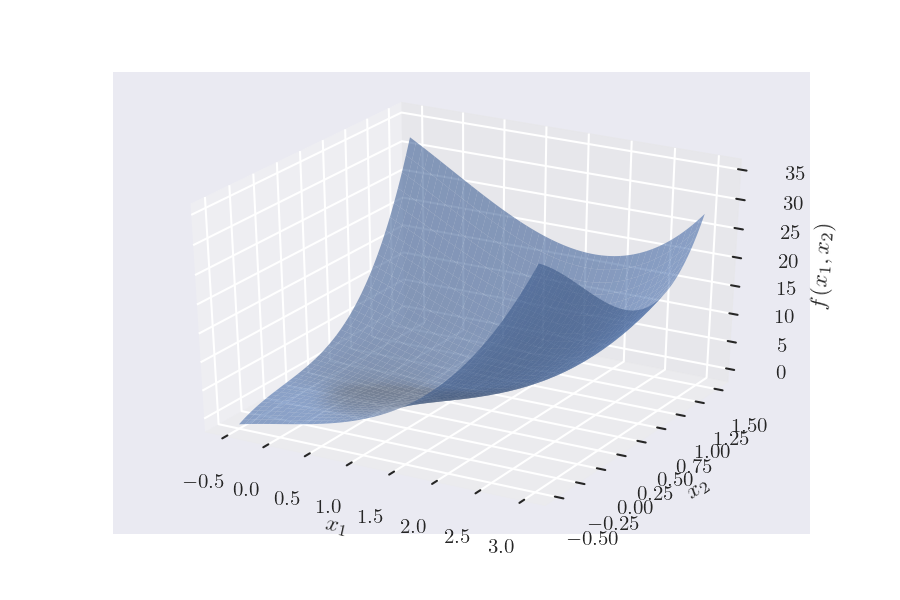

In [5]:
plot_surface(ff, xx1, xx2);

<IPython.core.display.Javascript object>


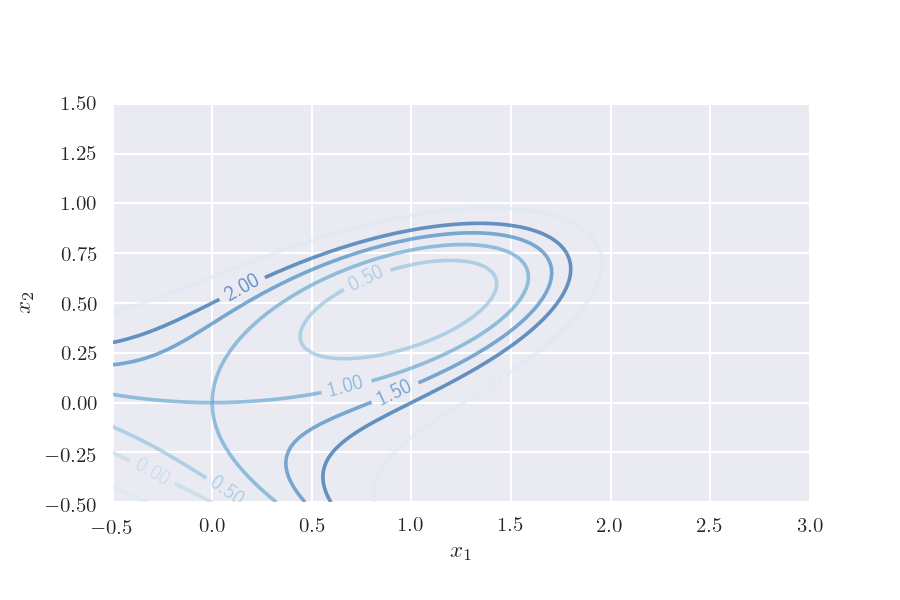

In [6]:
plot_contour(ff, xx1, xx2, levels=[-1, 0, 0.5, 1, 1.5, 2., 3]);

# Градиентные методы оптимизации 

Все рассмотренные методы имеют общую идею: построить последовательность $\mathbf{x}^{(0)}, \mathbf{x}^{(1)}, \mathbf{x}^{(2)}, ...$ так, чтобы значения функции в каждой следующей точке становились всё меньше и всё ближе к минимуму, причём переход от текущей точки $\mathbf{x}^{(k)}$ к следующей $\mathbf{x}^{(k+1)}$ каким-то образом учитывает тот факт, что антиградиент функции в точке $\mathbf{x}^{(k)}$ является направлением наибльшего уменьшения значения функции.

Для реализации вновь воспользуемся интерфейсом библиотеки `scipy.optimize`. Для градиентных методов в методе `minimize` предусмотрен параметр `jac`, который позволяет задать градиент (либо матрицу Якоби, если сама целевая функция является векторной). 

Рассмотрим детальнее, как происходит этот переход. Стартовать во всех случаях будем из точки $\mathbf{x}^{(0)}=(2, 1)$.

In [7]:
x0 = array([2, 1])

### A. Градиентный спуск с дроблением шага

Метод напрямую использует тот факт, что двигаться нужно вдоль направления антиградиента, и занимается подбором адекватной величины шага в этом направлении (достаточно малой, чтобы не перескочить локальный минимум, и достаточно большой, чтобы не ждать сходимости очень долго). Формула перехода имеет вид

$$\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - \alpha_k \nabla f(\mathbf{x}^{(k)}),$$

где $\alpha_k$ и регулирует величину шага. На каждой итерации сперва пробуется какое-то значение (например, 0,5), если оно устраивает (значение функции уменьшается) - переходят к следующим шагам, если нет - уменьшают его в два раза (и продолжают уменьшать, пока он нас не устроит).

In [15]:
def gradient_descent(func, x0, jac, args=(), 
                     alpha=0.5, tol=0.001, **options):
    k = 0
    X = [x0]
    F = [f(x0)]
    grad_fk = jac(X[k])
    while np.linalg.norm(grad_fk) >= tol:
        alphak = alpha
        X.append(X[k] - alphak*grad_fk)
        while f(X[k+1]) >= F[k]:
            alphak /= 2
            X[k+1] = X[k] - alphak*grad_fk
        F.append(f(X[k+1]))
        grad_fk = jac(X[k+1])
        k += 1
    return OptimizeResult(x=X[-1], fun=F[-1], jac=grad_fk, x_hist=np.c_[X].T, f_hist=array(F), nit=k)

In [17]:
res = minimize(f, x0, method=gradient_descent, jac=grad_f, tol=0.001, options=dict(alpha=0.1))
x1_hist, x2_hist = res.x_hist
print("Optimal point: (%.6f, %.6f).\nOptimal value: %.6f." % (res.x[0], res.x[1], res.fun))
print("Number of iterations for gradient descent method: %d." % res.nit)

Optimal point: (1.000114, 0.500018).
Optimal value: 0.000000.
Number of iterations for gradient descent method: 23.


Минимизирующая последовательность на графике функции:

<IPython.core.display.Javascript object>


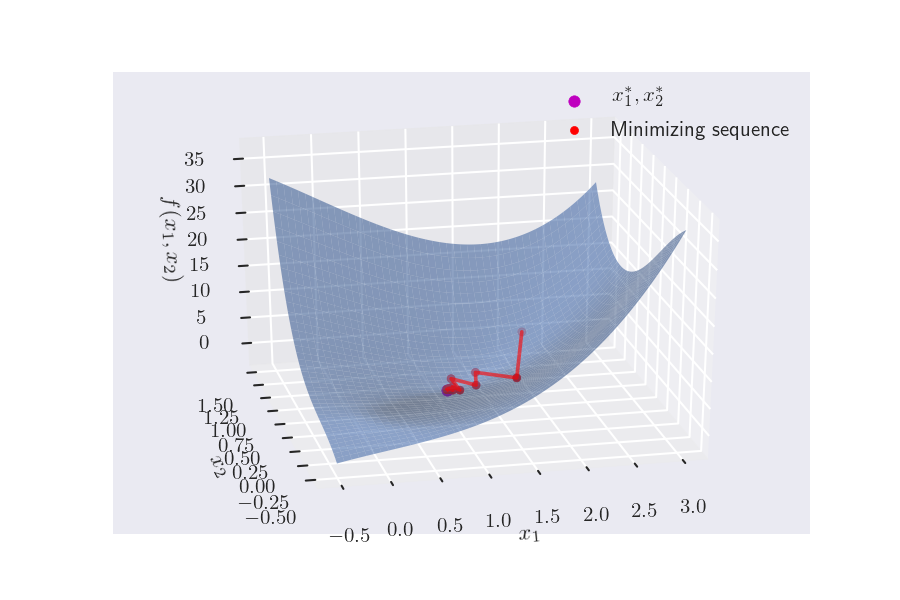

In [10]:
fig, ax = plot_surface(ff, xx1, xx2);
ax.scatter(res.x[0], res.x[1], f([res.x[0], res.x[1]]), c='m', s=30, label='$x_1^{*}, x_2^{*}$')
ax.scatter(x1_hist, x2_hist, f([x1_hist, x2_hist]), c='r', s=15, label='Minimizing sequence')
ax.plot(x1_hist, x2_hist, f([x1_hist, x2_hist]), c='r', alpha=0.6)
ax.legend();

Минимизирующая последовательность и линии уровня:

<IPython.core.display.Javascript object>


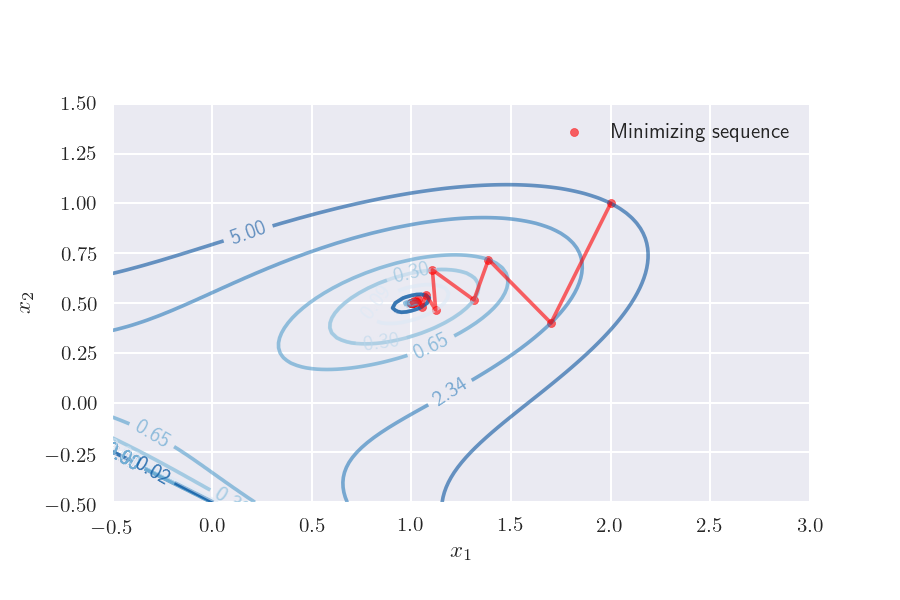

In [13]:
fig, ax = plot_contour(ff, xx1, xx2, levels=np.sort(res.f_hist))
ax.scatter(x1_hist, x2_hist, c='r', alpha=0.6, s=15, label='Minimizing sequence')
ax.plot(x1_hist, x2_hist, c='r', alpha=0.6)
ax.legend();

### В. Метод покоординатного спуска 

In [ ]:
def coordinate_descent(func, x0, tol, jac):
    pass

### С. Метод наискорейшего спуска 

In [ ]:
def steepest_descent(func, x0, tol, jac):
    pass